In [18]:
import os
import re
from pathlib import Path
import csv
import numpy as np
import pandas as pd
from scipy import stats
import sys
import glob
from skimage.transform import rescale


from PIL import Image

from collections import defaultdict

import pydicom
from pydicom.data import get_testdata_file
from pydicom import dcmread

from scipy.ndimage import rotate
from scipy.ndimage import map_coordinates

# !pip install SimpleITK
import SimpleITK as sitk
from skimage import morphology
from scipy import ndimage


import cv2
import matplotlib.pyplot as plt

In [3]:
directory = "/Users/kamleshranabhat/Desktop/Images/04-01-1960-NA-CT ABDOMENPELVIS W CONTRAST-03775/2.000000-AbdPelvis  5.0  B30f-23416"
file_name = "1-01.dcm"
file_path = os.path.join(directory, file_name)

if os.path.isdir(directory):
    print("Directory exists")

    print("Contents of the directory:")
    i=0
    for item in os.listdir(directory):
        while i<5:
            print(item)
            i = i+1
            break

    if os.path.exists(file_path):
        print(f"{file_name}File exists")
        
    else:
        print("File does not exist. Please check the file path.")
else:
    print("Directory does not exist. Please check the directory path.")


Directory exists
Contents of the directory:
1-81.dcm
1-42.dcm
1-56.dcm
1-57.dcm
1-43.dcm
1-01.dcmFile exists


In [4]:
ds = pydicom.dcmread(file_path)
print(ds)


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.1610.1211.142789310517751786980485018978
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.

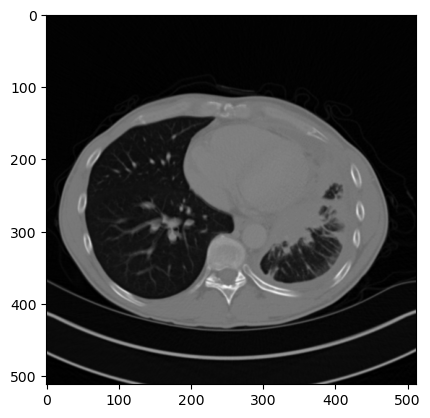

In [5]:
image_array = ds.pixel_array
plt.imshow(image_array, cmap="gray")


In [ ]:
# loading individual image

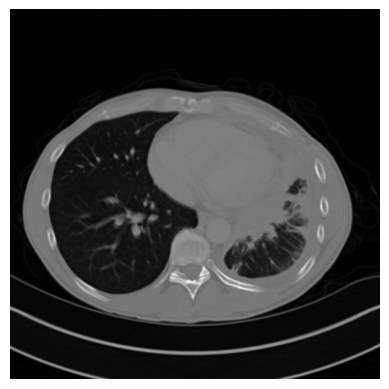


File path........: 1-01.dcm
SOP Class........: 1.2.840.10008.5.1.4.1.1.2 (CT Image Storage)

Name of Patient..: S0819-P201136072, 
Patient ID.......: S0819-P201136072
Image Type.........: CT
Date.......: 19600401
Rows X Columns ......: 512 x 512
Pixel Spacing....: [0.6953125, 0.6953125]
Cut Location ...: -223.7


In [6]:
plt.imshow(ds.pixel_array, cmap="gray")
plt.axis(False)
plt.show()

print()
print(f"File path........: {file_name}")
print(f"SOP Class........: {ds.SOPClassUID} ({ds.SOPClassUID.name})")
print()

patient_name = ds.PatientName
full_name = patient_name.family_name + ", " + patient_name.given_name
print(f"Name of Patient..: {full_name}")
print(f"Patient ID.......: {ds.PatientID}")
print(f"Image Type.........: {ds.Modality}")
print(f"Date.......: {ds.StudyDate}")
print(f"Rows X Columns ......: {ds.Rows} x {ds.Columns}")
print(f"Pixel Spacing....: {ds.PixelSpacing}")


print(f"Cut Location ...: {ds.get('SliceLocation', '(missing)')}")


In [ ]:
# loading images in range

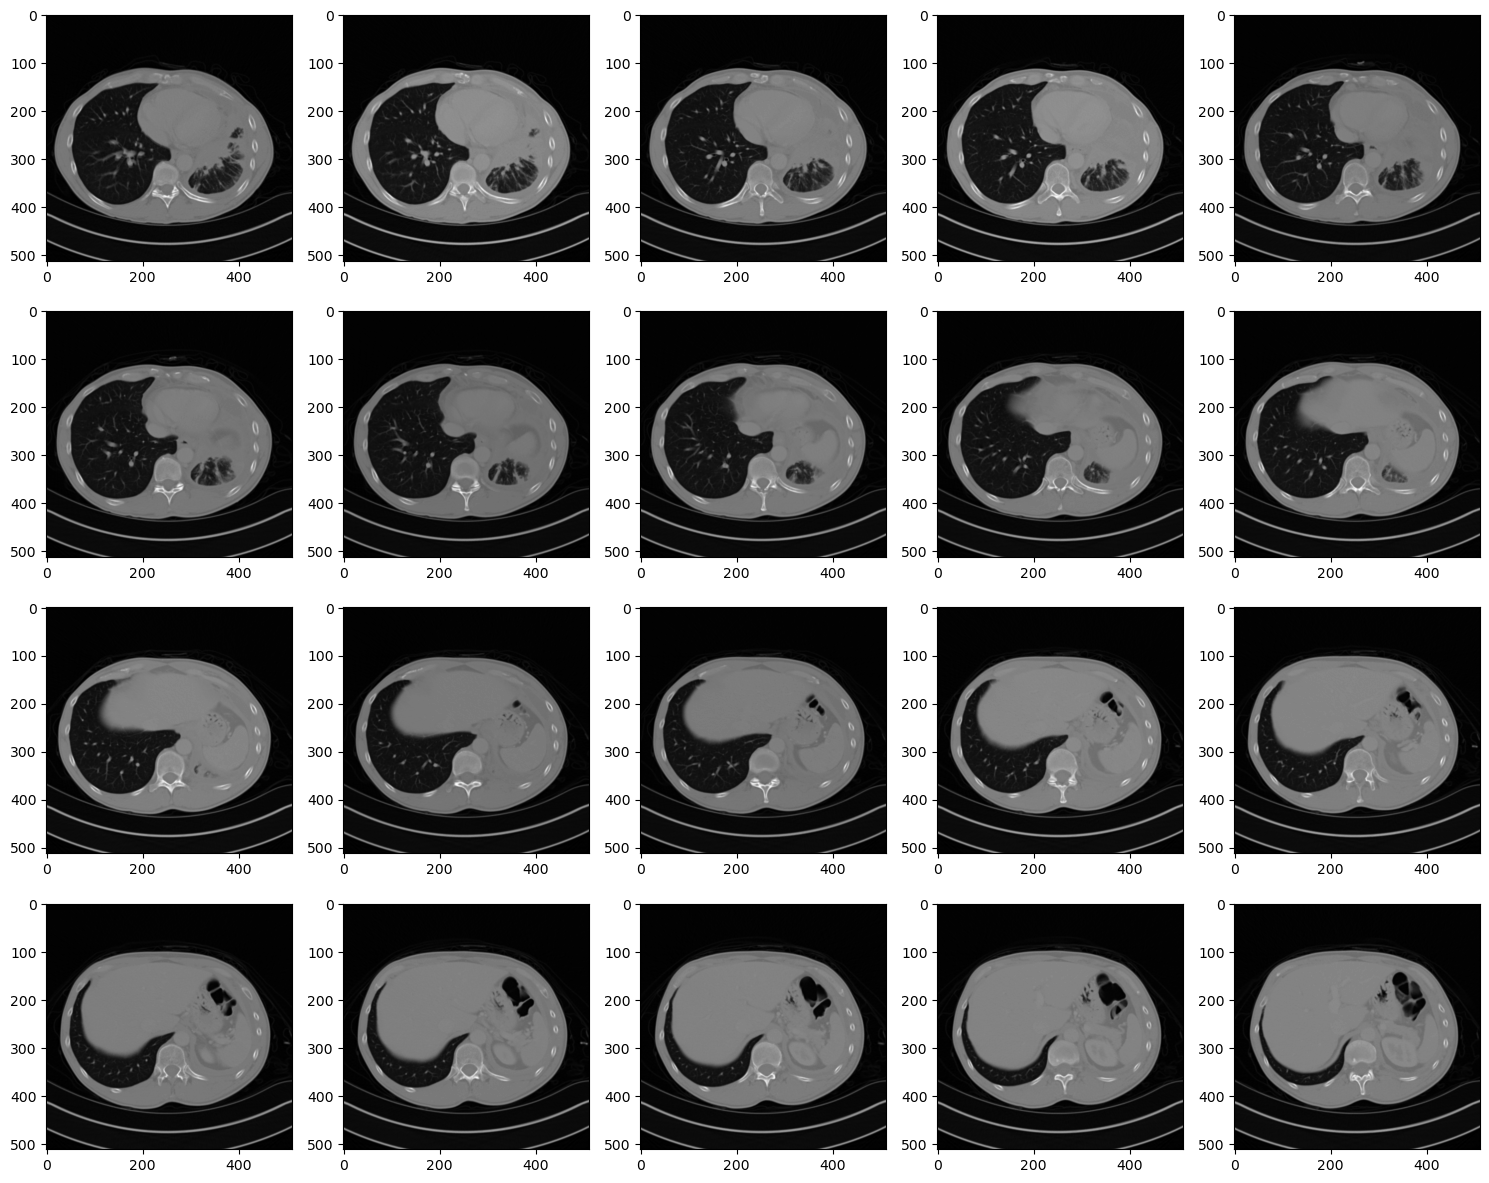

In [7]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 12))

for i in range(1, 21):
    if i < 10:
        fname = f"1-0{i}.dcm"
    else:
        fname = f"1-{i}.dcm"
        
    file_path = os.path.join(directory, fname)
    ds = pydicom.dcmread(file_path)
    
    row = (i - 1) // 5
    col = (i - 1) % 5
    
    axes[row, col].imshow(ds.pixel_array, cmap="gray")
#     axes[row, col].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# converting dicom image to jpg format

In [16]:
def get_names(path):
    names = []
    for root, dirnames, filenames in os.walk(path):
        for filename in filenames:
            _, ext = os.path.splitext(filename)
            if ext == '.dcm':
                names.append(os.path.join(root, filename))
    return names

def convert_dcm_to_jpg(file_path):
    ds = pydicom.dcmread(file_path)
    im = ds.pixel_array.astype(float)
    rescaled_image = (np.maximum(im, 0) / im.max()) * 255
    final_image = np.uint8(rescaled_image)
    return final_image


/Users/kamleshranabhat/Desktop/Images/04-01-1960-NA-CT ABDOMENPELVIS W CONTRAST-03775/2.000000-AbdPelvis  5.0  B30f-23416/1-81.jpg


In [20]:
def jpg_path(file_path):
    directory_path = os.path.dirname(file_path)

    jpg_img_directory = os.path.join(directory_path, 'JPG IMG')

    os.makedirs(jpg_img_directory, exist_ok=True)

    filename_without_ext = os.path.splitext(os.path.basename(file_path))[0]
    save_name = os.path.join(jpg_img_directory, f'{filename_without_ext}.jpg')

    return save_name


In [22]:
names = get_names(directory)

# print(names)

for name in names:
    save_name = jpg_path(name)
#     print(save_name)
    
    image = convert_dcm_to_jpg(name)
    
    pil_image = Image.fromarray(image)
    pil_image.save(save_name)
#     cv2.imshow(image)
#     break

In [41]:
# rotation of dicom image

In [120]:
def rotate_dicom(file_path, angle):
    ds = pydicom.dcmread(file_path, force=True)  # Force reading even if DICOM header is incomplete

    ds.SOPClassUID

    image = ds.pixel_array

    rotated_image = rotate(image, angle, reshape=False, order=1)
    rotated_image = np.rint(rotated_image).astype(np.uint16)

    ds.PixelData = rotated_image.tobytes()
    ds.Rows, ds.Columns = rotated_image.shape

    ds.file_meta = pydicom.Dataset()
    ds.file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian
    ds.is_little_endian = True
    ds.is_implicit_VR = False
        
    return ds


In [110]:
def rotate_dicom(dicom_file_path, angle):
    ds = pydicom.dcmread(dicom_file_path, force=True)
    
    image = ds.pixel_array

    rotated_image = rotate(image, angle, reshape=False, order=1)  # Bi-linear interpolation
    rotated_image = np.rint(rotated_image).astype(np.uint16)  # Ensure dtype is appropriate for DICOM

    rotated_ds = pydicom.dataset.Dataset()
    
    tags_to_copy = ['PatientID', 'PatientName', 'StudyInstanceUID', 'SeriesInstanceUID', 'SOPInstanceUID',
                    'StudyDate', 'StudyTime', 'PatientBirthDate', 'PatientSex', 'StudyDescription', 
                    'Manufacturer', 'Modality', 'BodyPartExamined', 'PatientPosition', 'SliceThickness', 
                    'PixelSpacing']
    
    for tag in tags_to_copy:
        if tag in ds:
            setattr(rotated_ds, tag, getattr(ds, tag))
    
    rotated_ds.Rows, rotated_ds.Columns = rotated_image.shape
    rotated_ds.PixelData = rotated_image.tobytes()
    rotated_ds.BitsAllocated = 16
    rotated_ds.BitsStored = 16
    rotated_ds.HighBit = 15
    rotated_ds.SamplesPerPixel = 1
    rotated_ds.PhotometricInterpretation = 'MONOCHROME2'
    rotated_ds.PixelRepresentation = 0
    rotated_ds.file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian
    
    rotated_ds.is_little_endian = True
    rotated_ds.is_implicit_VR = True

#     fig, axes = plt.subplots(1, 2, figsize=(10, 5))
#     axes[0].imshow(image, cmap='gray')
#     axes[0].set_title('Original Image')
#     axes[0].axis('off')
    
#     axes[1].imshow(rotated_image, cmap='gray')
#     axes[1].set_title(f'Rotated Image by {angle} degrees')
#     axes[1].axis('off')

#     plt.tight_layout()
#     plt.show()

    return rotated_ds



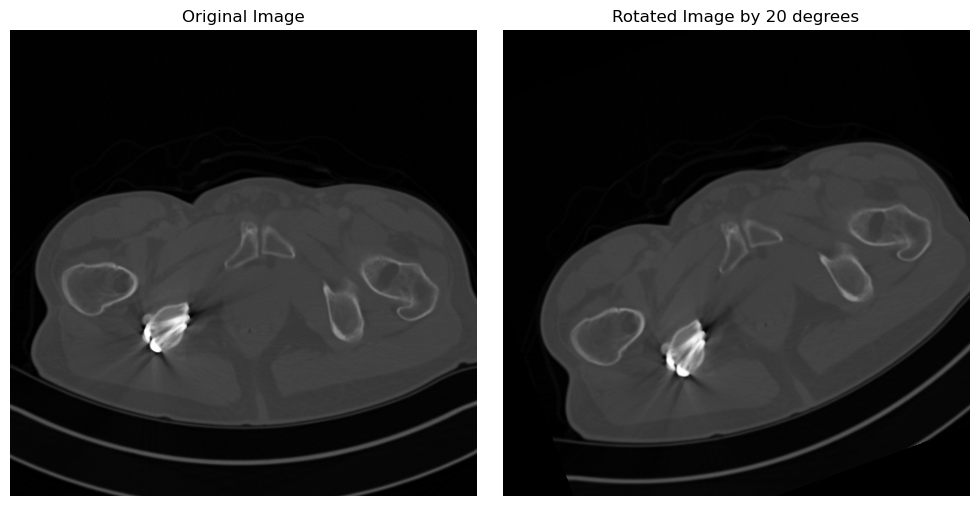

In [101]:
rotated_ds = rotate_dicom(file_path, 20)

In [122]:
for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    
    if os.path.isfile(file_path):
        try:
        #     print(file_path)
            save_path = rotated_path(file_path)
        #     print(save_path)
            rotated_dicom = rotate_dicom(file_path, 10)

            rotated_dicom.save_as(save_path)
        except Exception as e:
            print(e)
#     break


'FileDataset' object has no attribute 'SOPClassUID'


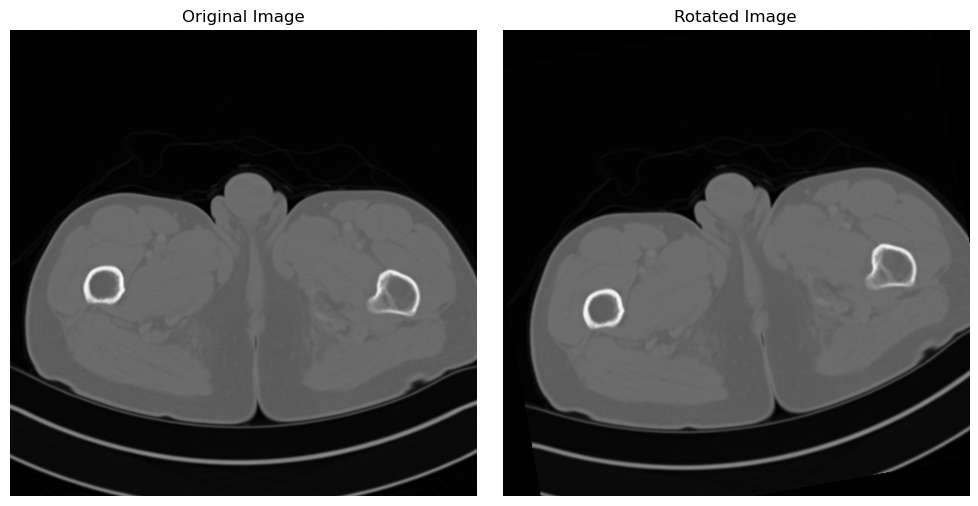

In [124]:
rotated_file_path = "/Users/kamleshranabhat/Desktop/Images/04-01-1960-NA-CT ABDOMENPELVIS W CONTRAST-03775/2.000000-AbdPelvis  5.0  B30f-23416/Rotated dcm/1-91.dcm"
file_path = "/Users/kamleshranabhat/Desktop/Images/04-01-1960-NA-CT ABDOMENPELVIS W CONTRAST-03775/2.000000-AbdPelvis  5.0  B30f-23416/1-91.dcm"

rds = pydicom.dcmread(rotated_file_path, force=True)
ds = pydicom.dcmread(file_path, force = True)

img = ds.pixel_array
rt_img = rds.pixel_array

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(rt_img, cmap='gray')
axes[1].set_title(f'Rotated Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [4]:
directory_path = "/Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Image/S0819-P200936563/02-12-1960-NA-CT Chest With Contrast-77799/2.000000-CHEST-75734"


In [7]:
files = []
print('glob: {}'.format(directory_path))
for fname in glob.glob(directory_path + '/*.dcm', recursive=False):
    print("loading: {}".format(fname))
    files.append(pydicom.dcmread(fname))
    

glob: /Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Image/S0819-P200936563/02-12-1960-NA-CT Chest With Contrast-77799/2.000000-CHEST-75734
loading: /Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Image/S0819-P200936563/02-12-1960-NA-CT Chest With Contrast-77799/2.000000-CHEST-75734/1-42.dcm
loading: /Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Image/S0819-P200936563/02-12-1960-NA-CT Chest With Contrast-77799/2.000000-CHEST-75734/1-56.dcm
loading: /Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Image/S0819-P200936563/02-12-1960-NA-CT Chest With Contrast-77799/2.000000-CHEST-75734/1-57.dcm
loading: /Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Image/S0819-P200936563/02-12-1960-NA-CT Chest With Contrast-77799/2.000000-CHEST-75734/1-43.dcm
loading: /Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Image/S0819-P200936563/02-12-1960-NA-CT Chest With Contrast-77799/2.000000-CHEST-75734/1-55.dcm
loading: /Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Image/S0819-P200936563/

In [10]:
slices = []
skipcount = 0
for f in files:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)
    else:
        skipcount += 1

print("file count: {}".format(len(files)))
print("skipped, no SliceLocation: {}".format(skipcount))


file count: 68
skipped, no SliceLocation: 0


In [71]:
def random_rotate3D(img_numpy, angle):
    assert img_numpy.ndim == 3, "provide a 3d numpy array"
    rotated_image = rotate(img_numpy, angle, reshape=False, order=5)
    return rotated_image

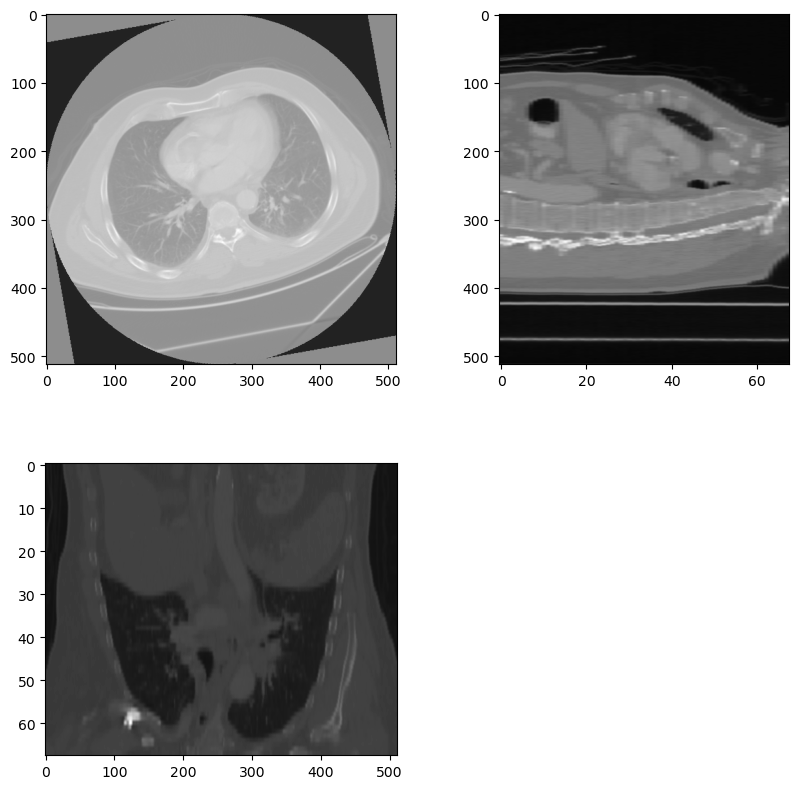

In [73]:
slices = sorted(slices, key=lambda s: s.SliceLocation)

# Pixel aspects, assuming all slices are the same
ps = slices[0].PixelSpacing
ss = slices[0].SliceThickness
ax_aspect = ps[1] / ps[0]
sag_aspect = ps[1] / ss
cor_aspect = ss / ps[0]

# Create 3D array
img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

# Fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d
    
img3d = random_rotate3D(img3d, 10)
plt.figure(figsize = (10,10))

# Plot 3 orthogonal slices
a1 = plt.subplot(2, 2, 1)
plt.imshow(img3d[:, :, img_shape[2] // 2], cmap = "gray")
a1.set_aspect(ax_aspect)

a2 = plt.subplot(2, 2, 2)
plt.imshow(img3d[:, img_shape[1] // 2, :], cmap = "gray")
a2.set_aspect(sag_aspect)

a3 = plt.subplot(2, 2, 3)
plt.imshow(img3d[img_shape[0] // 2, :, :].T, cmap = "gray")
a3.set_aspect(cor_aspect)

plt.show()


In [137]:
def translate_path(file_path):
    directory = os.path.dirname(file_path)
    filename = os.path.basename(file_path)
    save_directory = os.path.join(directory, 'Translate dcm')
    os.makedirs(save_directory, exist_ok=True)
    save_path = os.path.join(save_directory, filename)
    return save_path

In [63]:
def translate_dicom(dicom_file_path, translation_fraction):
    ds = pydicom.dcmread(dicom_file_path, force=True)
    ds.SOPClassUID
        
    image = ds.pixel_array.astype(float)
    
    rows, cols = image.shape
    
    translation_pixels = translation_fraction * np.array([rows, cols])
    
    x_coords, y_coords = np.meshgrid(np.arange(cols), np.arange(rows))
    
    translated_x_coords = x_coords + translation_pixels[1]
    translated_y_coords = y_coords + translation_pixels[0]
    
    translated_x_coords = np.clip(translated_x_coords, 0, cols - 1)
    translated_y_coords = np.clip(translated_y_coords, 0, rows - 1)
    
    translated_image = map_coordinates(image, [translated_y_coords, translated_x_coords], order=1, mode='nearest')
    
    translated_image = np.rint(translated_image).astype(np.uint16)
    
    ds.PixelData = translated_image.tobytes()
    ds.Rows, ds.Columns = translated_image.shape

    ds.file_meta = pydicom.Dataset()
    ds.file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian
    ds.is_little_endian = True
    ds.is_implicit_VR = False
        
    return translated_image, ds


In [140]:
for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    
    if os.path.isfile(file_path):
        try:
#             print(file_path)
            save_path = translate_path(file_path)
#             print(save_path)
            translated_image, dcm = translate_dicom(file_path, [0.1, 0.1])

            dcm.save_as(save_path)
        except Exception as e:
            print(e)
#     break


'FileDataset' object has no attribute 'SOPClassUID'


[0.05 0.05]


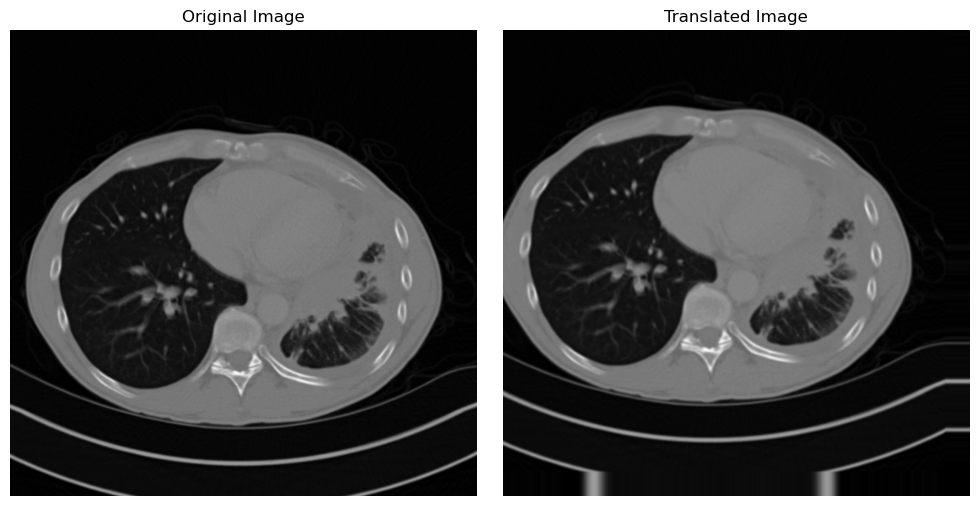

In [136]:
translation_fraction = np.array([0.05, 0.05])
print(translation_fraction)
translated_image, dcm = translate_dicom(dicom_file_path, translation_fraction)

translate_file_path = "/Users/kamleshranabhat/Desktop/Images/04-01-1960-NA-CT ABDOMENPELVIS W CONTRAST-03775/2.000000-AbdPelvis  5.0  B30f-23416/Translate dcm/1-91.dcm"
dcm.save_as(translate_file_path)

ds = pydicom.dcmread(dicom_file_path)
original_image = ds.pixel_array

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(translated_image, cmap='gray')
plt.title('Translated Image')
plt.axis('off')

plt.tight_layout()
plt.show()


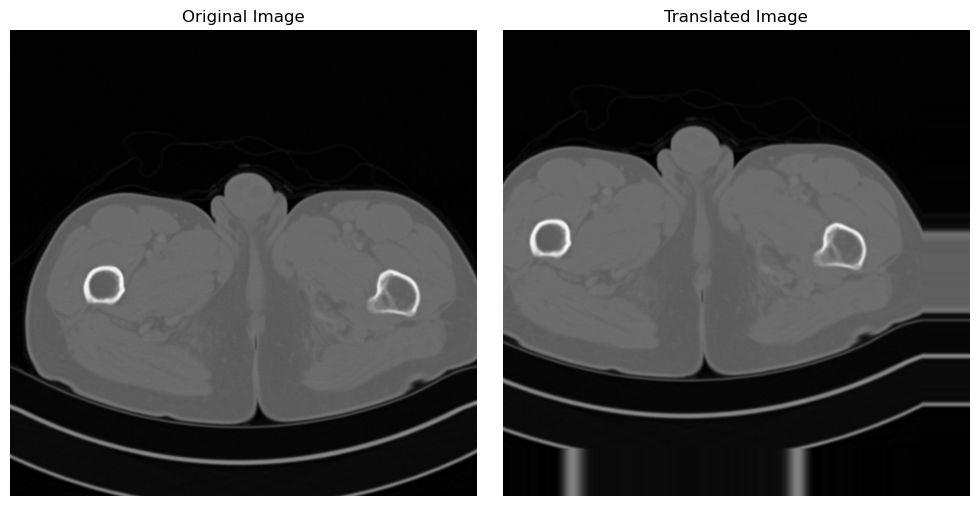

In [142]:
translated_file_path = "/Users/kamleshranabhat/Desktop/Images/04-01-1960-NA-CT ABDOMENPELVIS W CONTRAST-03775/2.000000-AbdPelvis  5.0  B30f-23416/Translate dcm/1-91.dcm"
file_path = "/Users/kamleshranabhat/Desktop/Images/04-01-1960-NA-CT ABDOMENPELVIS W CONTRAST-03775/2.000000-AbdPelvis  5.0  B30f-23416/1-91.dcm"

tds = pydicom.dcmread(translated_file_path, force=True)
ds = pydicom.dcmread(file_path, force = True)

img = ds.pixel_array
ts_img = tds.pixel_array

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(ts_img, cmap='gray')
axes[1].set_title(f'Translated Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [125]:
# resizing image

(512, 512)
The image has 512 x 512 voxels
The downsampled image has 128 x 128 voxels
(128, 128)


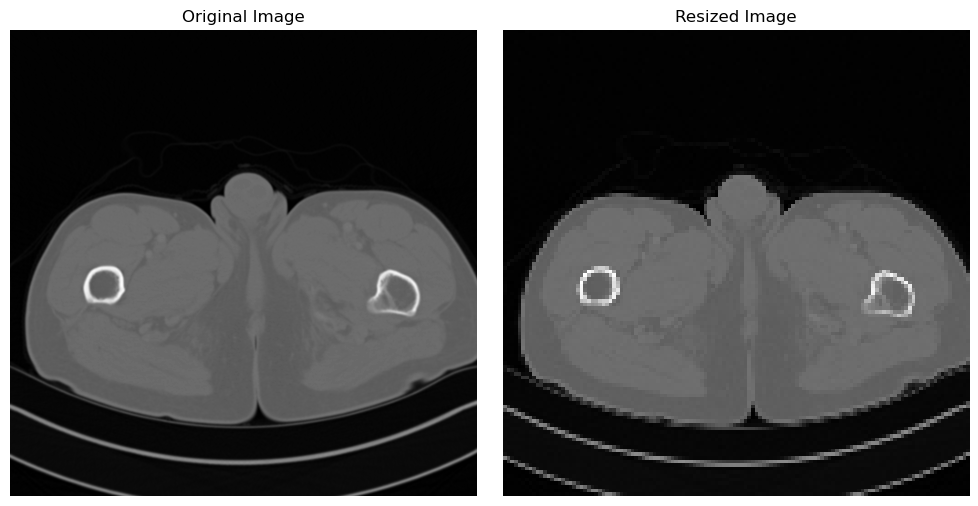

In [151]:
file_path = "/Users/kamleshranabhat/Desktop/Images/04-01-1960-NA-CT ABDOMENPELVIS W CONTRAST-03775/2.000000-AbdPelvis  5.0  B30f-23416/1-91.dcm"
resize_path = "/Users/kamleshranabhat/Desktop/Images/04-01-1960-NA-CT ABDOMENPELVIS W CONTRAST-03775/2.000000-AbdPelvis  5.0  B30f-23416/Resize dcm/1-91.dcm"
ds = pydicom.dcmread(file_path)

data = ds.pixel_array
print(data.shape)
print('The image has {} x {} voxels'.format(data.shape[0], data.shape[1]))

data_downsampling = data[::4, ::4]
print('The downsampled image has {} x {} voxels'.format(data_downsampling.shape[0], data_downsampling.shape[1]))

ds.PixelData = data_downsampling.tobytes()

ds.Rows, ds.Columns = data_downsampling.shape
print(data_downsampling.shape)

ds.save_as(resize_path)

ds.file_meta = pydicom.Dataset()
ds.file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian
ds.is_little_endian = True
ds.is_implicit_VR = False

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(data, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(data_downsampling, cmap='gray')
axes[1].set_title(f'Resized Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()



In [160]:
# Level and window for dicom

In [156]:
def show_slice_window(slice, level, window):
    max = level + window/2
    min = level - window/2
    
    slice = slice.clip(min,max)
    
    plt.imshow(slice, cmap="gray")
    

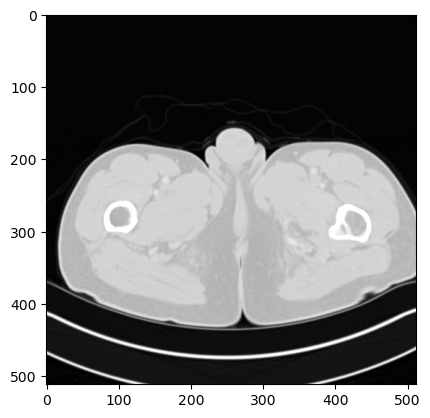

In [162]:
file_path = "/Users/kamleshranabhat/Desktop/Images/04-01-1960-NA-CT ABDOMENPELVIS W CONTRAST-03775/2.000000-AbdPelvis  5.0  B30f-23416/1-91.dcm"
ds = pydicom.dcmread(file_path)

slice = ds.pixel_array

show_slice_window(slice, 400, 1800)

In [11]:
# loading images ad 3D slides

In [12]:
directory_path = "/Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Image/S0819-P200936563/02-12-1960-NA-CT Chest With Contrast-77799/2.000000-CHEST-75734"


In [13]:
files = []
print('glob: {}'.format(directory_path))
for fname in glob.glob(directory_path + '/*.dcm', recursive=False):
    print("loading: {}".format(fname))
    files.append(pydicom.dcmread(fname))


glob: /Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Image/S0819-P200936563/02-12-1960-NA-CT Chest With Contrast-77799/2.000000-CHEST-75734
loading: /Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Image/S0819-P200936563/02-12-1960-NA-CT Chest With Contrast-77799/2.000000-CHEST-75734/1-42.dcm
loading: /Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Image/S0819-P200936563/02-12-1960-NA-CT Chest With Contrast-77799/2.000000-CHEST-75734/1-56.dcm
loading: /Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Image/S0819-P200936563/02-12-1960-NA-CT Chest With Contrast-77799/2.000000-CHEST-75734/1-57.dcm
loading: /Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Image/S0819-P200936563/02-12-1960-NA-CT Chest With Contrast-77799/2.000000-CHEST-75734/1-43.dcm
loading: /Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Image/S0819-P200936563/02-12-1960-NA-CT Chest With Contrast-77799/2.000000-CHEST-75734/1-55.dcm
loading: /Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Image/S0819-P200936563/

file count: 68
skipped, no SliceLocation: 0


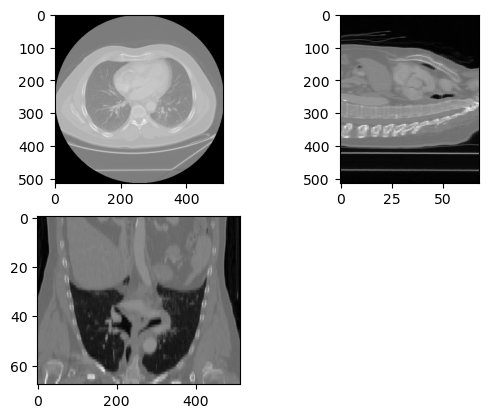

In [15]:
slices = []
skipcount = 0
for f in files:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)
    else:
        skipcount += 1

print("file count: {}".format(len(files)))
print("skipped, no SliceLocation: {}".format(skipcount))

# Ensure slices are in correct order
slices = sorted(slices, key=lambda s: s.SliceLocation)

# Pixel aspects, assuming all slices are the same
ps = slices[0].PixelSpacing
ss = slices[0].SliceThickness
ax_aspect = ps[1] / ps[0]
sag_aspect = ps[1] / ss
cor_aspect = ss / ps[0]

# Create 3D array
img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

# Fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d

# Plot 3 orthogonal slices
a1 = plt.subplot(2, 2, 1)
plt.imshow(img3d[:, :, img_shape[2] // 2], cmap = "gray")
a1.set_aspect(ax_aspect)

a2 = plt.subplot(2, 2, 2)
plt.imshow(img3d[:, img_shape[1] // 2, :], cmap = "gray")
a2.set_aspect(sag_aspect)

a3 = plt.subplot(2, 2, 3)
plt.imshow(img3d[img_shape[0] // 2, :, :].T, cmap = "gray")
a3.set_aspect(cor_aspect)

plt.show()


In [9]:
import pydicom
import numpy as np
import hashlib
import scipy.ndimage as ndi
import pywt


In [14]:
class DICOMNoiseHandler:
    def __init__(self, dicom_path):
        self.dicom_path = dicom_path #stores path to dicom file
        self.dicom_data = pydicom.dcmread(dicom_path)  #reads dicom image
        self.image_data = self.dicom_data.pixel_array  #extracts pixel array(image data)
        self.noise_iteration_id = None  #stores iteration id when noise is added
        self.noise_level = None  #stores noise level
        self.image_dimension = self.image_data.shape  #dimension of image data
        self.image_spacing = (self.dicom_data.PixelSpacing[0], self.dicom_data.PixelSpacing[1], self.dicom_data.SliceThickness) #image spacing i.e pixelspacing and slicethickness which is extracted from dicom metadata

        
    def update_hash(self, m):
        m.update(self.image_data.tobytes())  #updates hash object with image data
        return m
    

    def get_voxel_grid(self):
        return self.image_data.copy()  #returns a copy of current image data
    

    def set_voxel_grid(self, voxel_grid):
        self.image_data = voxel_grid  #updates the image data with current voxel grid
        

    def update_image_data(self):
        self.dicom_data.PixelData = self.image_data.tobytes()  #updates pixel data with current image data
        
    def is_empty(self):
        return self.image_data is None
        
# to add gaussian noise to the image
    def add_noise(self, noise_level, noise_iteration_id):
        """
         Adds Gaussian noise to the image volume
         noise_level: standard deviation of image noise present """

        self.noise_iteration_id = noise_iteration_id

        if self.image_data is None:
            return

        # Skip for invalid noise levels
        if noise_level is None:
            return
        if np.isnan(noise_level) or noise_level < 0.0:
            return

        # Set noise level in image
        self.noise_level = noise_level

        m = hashlib.sha1(usedforsecurity=False)
        m = self.update_hash(m=m)
        randomiser = np.random.default_rng(int(m.hexdigest(), 16))

        voxel_grid = self.get_voxel_grid().astype(np.float64)
        voxel_grid += randomiser.normal(loc=0.0, scale=noise_level, size=self.image_dimension)
        voxel_grid = np.clip(voxel_grid, np.iinfo(self.image_data.dtype).min, np.iinfo(self.image_data.dtype).max).astype(self.image_data.dtype)

        self.set_voxel_grid(voxel_grid=voxel_grid)
        self.update_image_data()


    def estimate_noise(self, method="chang"):
        # Skip if the image is missing
        if self.is_empty():
            return

        if method == "rank":
            """ Estimate image noise level using the method by Rank, Lendl and Unbehauen, Estimation of 
            image noise variance, IEEE Proc. Vis. Image Signal Process (1999) 146:80-84"""

            # Step 1: filter with a cascading difference filter to suppress original image
            difference_filter = np.array([-1.0 / np.sqrt(2.0), 1.0 / np.sqrt(2.0)])

            # Filter voxel volume
            response_map = ndi.convolve1d(self.get_voxel_grid(), weights=difference_filter, axis=1)
            response_map = ndi.convolve1d(response_map, weights=difference_filter, axis=2)

            # Step 2: compute histogram of local standard deviation and calculate histogram
            # Calculate local means
            local_means = ndi.uniform_filter(response_map, size=[1, 3, 3])

            # Calculate local sum of squares
            sum_filter = np.array([1.0, 1.0, 1.0]) / 3.0
            local_sum_square = ndi.convolve1d(np.power(response_map, 2.0), weights=sum_filter, axis=1)
            local_sum_square = ndi.convolve1d(local_sum_square, weights=sum_filter, axis=2)

            # Calculate local variance
            local_variance = 1.0 / 8.0 * (local_sum_square - 9.0 * np.power(local_means, 2.0))

            # Step 3: calculate median noise - this differs from the original
            # Set local variances below 0 (due to floating point rounding) to 0.
            local_variance = np.ravel(local_variance)
            local_variance[local_variance < 0.0] = 0.0

            # Select robust range (within IQR)
            local_variance = local_variance[np.logical_and(
                local_variance >= np.percentile(local_variance, 25),
                local_variance <= np.percentile(local_variance, 75)
            )]

            # Calculate Gaussian noise
            estimated_noise = np.sqrt(np.mean(local_variance))

        elif method == "ikeda":
            """ Estimate image noise level using a method by Ikeda, Makino, Imai et al., A method for estimating noise
             variance of CT image, Comp Med Imaging Graph (2010) 34:642-650"""

            # Step 1: filter with a cascading difference filter to suppress original image volume
            diff_filter = np.array([-1.0 / np.sqrt(2.0), 1.0 / np.sqrt(2.0)])

            # Filter voxel volume
            response_map = ndi.convolve1d(self.get_voxel_grid(), weights=diff_filter, axis=1)
            response_map = ndi.convolve1d(response_map, weights=diff_filter, axis=2)

            # Step 2: calculate median noise
            estimated_noise = np.median(np.abs(response_map)) / 0.6754

        elif method == "chang":
            """ Noise estimation based on wavelets used in Chang, Yu and Vetterli, Adaptive wavelet thresholding for image
            denoising and compression. IEEE Trans Image Proc (2000) 9:1532-1546"""

            import pywt

            # Step 1: calculate HH subband of the wavelet transformation
            # Generate digital wavelet filter
            hi_filt = np.array(pywt.Wavelet("coif1").dec_hi)

            # Calculate HH subband image
            response_map = ndi.convolve1d(self.get_voxel_grid(), weights=hi_filt, axis=1)
            response_map = ndi.convolve1d(response_map, weights=hi_filt, axis=2)

            # Step 2: calculate median noise
            estimated_noise = np.median(np.abs(response_map)) / 0.6754

        elif method == "immerkaer":
            """ Noise estimation based on laplacian filtering, described in Immerkaer, Fast noise variance estimation.
            Comput Vis Image Underst (1995) 64:300-302"""

            # Step 1: construct filter and filter voxel volume
            # Create filter
            noise_filt = np.array([[1.0, -2.0, 1.0], [-2.0, 4.0, -2.0], [1.0, -2.0, 1.0]], ndmin=3)

            # Apply filter
            response_map = ndi.convolve(self.get_voxel_grid(), weights=noise_filt)

            # Step 2: calculate noise level
            estimated_noise = np.sqrt(np.mean(np.power(response_map, 2.0))) / 36.0

        elif method == "zwanenburg":
            """ Noise estimation based on blob detection for weighting immerkaer filtering """

            # Step 1: construct laplacian filter and filter voxel volume
            # Create filter
            noise_filt = np.array([[1.0, -2.0, 1.0], [-2.0, 4.0, -2.0], [1.0, -2.0, 1.0]], ndmin=3)

            # Apply filter
            response_map = ndi.convolve(self.get_voxel_grid(), weights=noise_filt)
            response_map = np.power(response_map, 2.0)

            # Step 2: construct blob weighting
            # Spacing for gaussian
            gauss_filt_spacing = np.full(shape=3, fill_value=np.min(self.image_spacing))
            gauss_filt_spacing = np.divide(gauss_filt_spacing, np.array(self.image_spacing))

            # Difference of gaussians
            weight_vox = ndi.gaussian_filter(
                self.get_voxel_grid(),
                sigma=1.0 * gauss_filt_spacing
            ) - ndi.gaussian_filter(
                self.get_voxel_grid(),
                sigma=4.0 * gauss_filt_spacing
            )

            # Smooth edge detection
            weight_vox = ndi.gaussian_filter(np.abs(weight_vox), sigma=2.0 * gauss_filt_spacing)

            # Convert to weighting scale
            weight_vox = 1.0 - weight_vox / np.max(weight_vox)

            # Decrease weight of edge voxels
            weight_vox = np.power(weight_vox, 2.0)

            # Step 3: estimate noise level
            estimated_noise = np.sqrt(np.sum(np.multiply(response_map, weight_vox)) / (36.0 * np.sum(weight_vox)))

        else:
            raise ValueError(
                "The provided noise estimation method is not implemented. Use one of \"chang\" (default), "
                "\"rank\", \"ikeda\", \"immerkaer\" or \"zwanenburg\"."
            )

        return estimated_noise
        

In [15]:
dicom_handler = DICOMNoiseHandler('/Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Image/S0819-P200936563/12-29-1959-NA-CT Chest With Contrast-96665/2.000000-CHEST-57436/1-32.dcm')
dicom_handler.add_noise(noise_level=5.0, noise_iteration_id=1)
estimated_noise = dicom_handler.estimate_noise(method="chang")
print(f"Estimated noise level: {estimated_noise}")
dicom_handler.save_dicom('/Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Image/S0819-P200936563/12-29-1959-NA-CT Chest With Contrast-96665/noise.dcm')

AxisError: axis 2 is out of bounds for array of dimension 2

In [136]:
import os
import pydicom
import numpy as np
import hashlib
import scipy.ndimage as ndi
import pywt

class DICOMNoiseHandler:
    def __init__(self, dicom_dir):
        self.dicom_dir = dicom_dir
        self.dicom_files = [os.path.join(dicom_dir, f) for f in os.listdir(dicom_dir) if f.endswith('.dcm')]
        self.dicom_data_list = [pydicom.dcmread(f) for f in self.dicom_files]
        self.image_data = np.stack([data.pixel_array for data in self.dicom_data_list])
        self.noise_iteration_id = None
        self.noise_level = None
        self.image_dimension = self.image_data.shape
        self.image_spacing = self.dicom_data_list[0].PixelSpacing if hasattr(self.dicom_data_list[0], 'PixelSpacing') else (1.0, 1.0, 1.0)
        self.max_val = np.iinfo(self.image_data.dtype).max
        self.min_val = np.iinfo(self.image_data.dtype).min
        
        
    def update_hash(self, m):
        m.update(self.image_data.tobytes())
        return m

    def get_voxel_grid(self):
        return self.image_data.copy()

    def set_voxel_grid(self, voxel_grid):
        self.image_data = voxel_grid

    def update_image_data(self):
        for i, dicom_data in enumerate(self.dicom_data_list):
            dicom_data.PixelData = self.image_data[i].tobytes()

    def is_empty(self):
        return self.image_data is None

#gaussian noise

    def add_noise(self, noise_level, noise_iteration_id):
        self.noise_iteration_id = noise_iteration_id

        if self.image_data is None:
            return

        if noise_level is None or np.isnan(noise_level) or noise_level < 0.0:
            return

        self.noise_level = noise_level

        m = hashlib.sha1(usedforsecurity=False)
        m = self.update_hash(m=m)
        randomiser = np.random.default_rng(int(m.hexdigest(), 16))

        voxel_grid = self.get_voxel_grid().astype(np.float64)
        voxel_grid += randomiser.normal(loc=0.0, scale=noise_level, size=self.image_dimension)
        voxel_grid = np.clip(voxel_grid, np.iinfo(self.image_data.dtype).min, np.iinfo(self.image_data.dtype).max).astype(self.image_data.dtype)

        self.set_voxel_grid(voxel_grid=voxel_grid)
        self.update_image_data()
        
    def add_salt_and_pepper_noise(self, salt_prob=0.01, pepper_prob=0.01):
        if self.image_data is None:
            return

        voxel_grid = self.get_voxel_grid()

        # Generate salt noise
        salt_mask = np.random.random(self.image_dimension) < salt_prob
        voxel_grid[salt_mask] = 255.0

        # Generate pepper noise
        pepper_mask = np.random.random(self.image_dimension) < pepper_prob
        voxel_grid[pepper_mask] = 0.0

        self.set_voxel_grid(voxel_grid=voxel_grid)
        self.update_image_data()
        
    def add_speckle_noise(self, noise_std_dev):
        if self.image_data is None:
            return

        voxel_grid = self.get_voxel_grid()

        # Generate speckle noise
        noise = np.random.normal(loc=0.0, scale=noise_std_dev, size=self.image_dimension)
        noisy_voxel_grid = voxel_grid + voxel_grid * noise

        # Clip the values to the data type limits
        noisy_voxel_grid = np.clip(noisy_voxel_grid, self.min_val, self.max_val).astype(self.image_data.dtype)

        self.set_voxel_grid(voxel_grid=noisy_voxel_grid)
        self.update_image_data()
        
    def add_poisson_noise(self):
        if self.image_data is None:
            return

        voxel_grid = self.get_voxel_grid()

        if np.any(voxel_grid < 0):
            voxel_grid = np.clip(voxel_grid, 0, None)
        if np.isnan(voxel_grid).any():
            voxel_grid = np.nan_to_num(voxel_grid)

        # Generate Poisson-distributed noise
        noisy_voxel_grid = np.random.poisson(voxel_grid)

        # Clip the values to the data type limits
        noisy_voxel_grid = np.clip(noisy_voxel_grid, self.min_val, self.max_val).astype(self.image_data.dtype)

        self.set_voxel_grid(voxel_grid=noisy_voxel_grid)
        self.update_image_data()
        
        
    def estimate_noise(self, method="chang"):
        if self.is_empty():
            return

        if method == "rank":
            difference_filter = np.array([-1.0 / np.sqrt(2.0), 1.0 / np.sqrt(2.0)])
            response_map = ndi.convolve1d(self.get_voxel_grid(), weights=difference_filter, axis=0)
            response_map = ndi.convolve1d(response_map, weights=difference_filter, axis=1)
            response_map = ndi.convolve1d(response_map, weights=difference_filter, axis=2)
            local_means = ndi.uniform_filter(response_map, size=[3, 3, 3])
            sum_filter = np.array([1.0, 1.0, 1.0]) / 3.0
            local_sum_square = ndi.convolve1d(np.power(response_map, 2.0), weights=sum_filter, axis=0)
            local_sum_square = ndi.convolve1d(local_sum_square, weights=sum_filter, axis=1)
            local_sum_square = ndi.convolve1d(local_sum_square, weights=sum_filter, axis=2)
            local_variance = 1.0 / 8.0 * (local_sum_square - 9.0 * np.power(local_means, 2.0))
            local_variance = np.ravel(local_variance)
            local_variance[local_variance < 0.0] = 0.0
            local_variance = local_variance[np.logical_and(
                local_variance >= np.percentile(local_variance, 25),
                local_variance <= np.percentile(local_variance, 75)
            )]
            estimated_noise = np.sqrt(np.mean(local_variance))

        elif method == "ikeda":
            diff_filter = np.array([-1.0 / np.sqrt(2.0), 1.0 / np.sqrt(2.0)])
            response_map = ndi.convolve1d(self.get_voxel_grid(), weights=diff_filter, axis=0)
            response_map = ndi.convolve1d(response_map, weights=diff_filter, axis=1)
            response_map = ndi.convolve1d(response_map, weights=diff_filter, axis=2)
            estimated_noise = np.median(np.abs(response_map)) / 0.6754

        elif method == "chang":
            hi_filt = np.array(pywt.Wavelet("coif1").dec_hi)
            response_map = ndi.convolve1d(self.get_voxel_grid(), weights=hi_filt, axis=0)
            response_map = ndi.convolve1d(response_map, weights=hi_filt, axis=1)
            response_map = ndi.convolve1d(response_map, weights=hi_filt, axis=2)
            estimated_noise = np.median(np.abs(response_map)) / 0.6754

        elif method == "immerkaerzwanenburg":
            noise_filt = np.array([[[1.0, -2.0, 1.0], [-2.0, 4.0, -2.0], [1.0, -2.0, 1.0]]])
            response_map = ndi.convolve(self.get_voxel_grid(), weights=noise_filt)
            estimated_noise = np.sqrt(np.mean(np.power(response_map, 2.0))) / 36.0

        elif method == "zwanenburg":
            noise_filt = np.array([[1.0, -2.0, 1.0], [-2.0, 4.0, -2.0], [1.0, -2.0, 1.0]], ndmin=3)
            response_map = ndi.convolve(self.get_voxel_grid(), weights=noise_filt)
            response_map = np.power(response_map, 2.0)

            # Adjusted for 3D
            gauss_filt_spacing = np.full(shape=3, fill_value=np.min(self.image_spacing[:3]))
            print(gauss_filt_spacing)
            print(np.array(self.image_spacing))
            print(self.image_spacing)
            gauss_filt_spacing = np.divide(gauss_filt_spacing, np.array(self.image_spacing))

            weight_vox = ndi.gaussian_filter(
                self.get_voxel_grid(),
                sigma=1.0 * gauss_filt_spacing
            ) - ndi.gaussian_filter(
                self.get_voxel_grid(),
                sigma=4.0 * gauss_filt_spacing
            )
            weight_vox = ndi.gaussian_filter(np.abs(weight_vox), sigma=2.0 * gauss_filt_spacing)
            weight_vox = 1.0 - weight_vox / np.max(weight_vox)
            weight_vox = np.power(weight_vox, 2.0)
            estimated_noise = np.sqrt(np.sum(np.multiply(response_map, weight_vox)) / (36.0 * np.sum(weight_vox)))

        else:
            raise ValueError(
                "The provided noise estimation method is not implemented. Use one of \"chang\" (default), "
                "\"rank\", \"ikeda\", \"immerkaer\" or \"zwanenburg\"."
            )

        return estimated_noise

    def save_dicom(self, output_dir):
        for i, dicom_data in enumerate(self.dicom_data_list):
            output_path = os.path.join(output_dir, os.path.basename(self.dicom_files[i]))
            dicom_data.save_as(output_path)



In [137]:
def directory_path(path):
    if not os.path.exists(path):
        os.makedirs(path)
    return path

In [138]:
dicom_handler = DICOMNoiseHandler('/Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Image/S0819-P200936563/12-29-1959-NA-CT Chest With Contrast-96665/2.000000-CHEST-57436')
dicom_handler.add_speckle_noise(noise_std_dev = 0.05)
estimated_noise = dicom_handler.estimate_noise(method="zwanenburg")
print(f"Estimated noise level: {estimated_noise}")

save_path = directory_path('/Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Image/S0819-P200936563/12-29-1959-NA-CT Chest With Contrast-96665/zwanenburg')

dicom_handler.save_dicom(save_path)

[0.800781 0.800781 0.800781]
[0.800781 0.800781]
[0.800781, 0.800781]


ValueError: operands could not be broadcast together with shapes (3,) (2,) 

file count: 68
skipped, no SliceLocation: 0


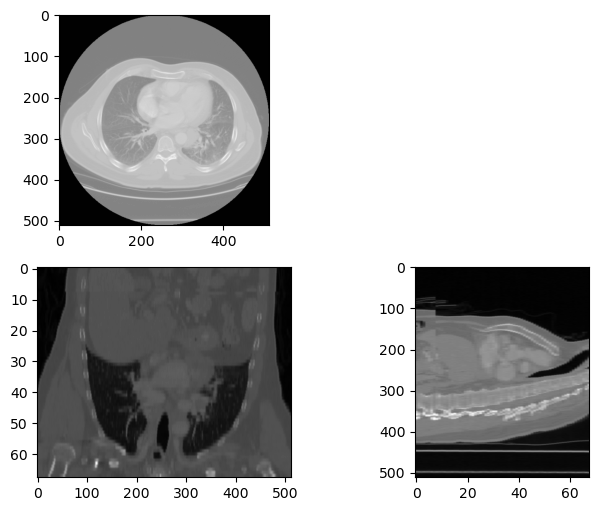

In [74]:
directory_path = '/Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Image/S0819-P200936563/12-29-1959-NA-CT Chest With Contrast-96665/rank_5'

files = []
# print('glob: {}'.format(directory_path))
for fname in glob.glob(directory_path + '/*.dcm', recursive=False):
#     print("loading: {}".format(fname))
    files.append(pydicom.dcmread(fname))
    
slices = []
skipcount = 0
for f in files:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)
    else:
        skipcount += 1

print("file count: {}".format(len(files)))
print("skipped, no SliceLocation: {}".format(skipcount))

# Ensure slices are in correct order
slices = sorted(slices, key=lambda s: s.SliceLocation)

# Pixel aspects, assuming all slices are the same
ps = slices[0].PixelSpacing
ss = slices[0].SliceThickness
ax_aspect = ps[1] / ps[0]
sag_aspect = ps[1] / ss
cor_aspect = ss / ps[0]

# Create 3D array
img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

# Fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d

plt.figure(figsize=(8, 6))
    
a1 = plt.subplot(2, 2, 1)
axial = img3d[:, :, img_shape[2] // 2]

# axial = rescale(axial, scale = 10, anti_aliasing =False)

plt.imshow(axial, cmap = "gray")
a1.set_aspect(ax_aspect)

a2 = plt.subplot(2, 2, 4)
plt.imshow(img3d[:, img_shape[1] // 2, :], cmap = "gray")
a2.set_aspect(sag_aspect)

a3 = plt.subplot(2, 2, 3)
plt.imshow(img3d[img_shape[0] // 2, :, :].T, cmap = "gray")
a3.set_aspect(cor_aspect)

plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

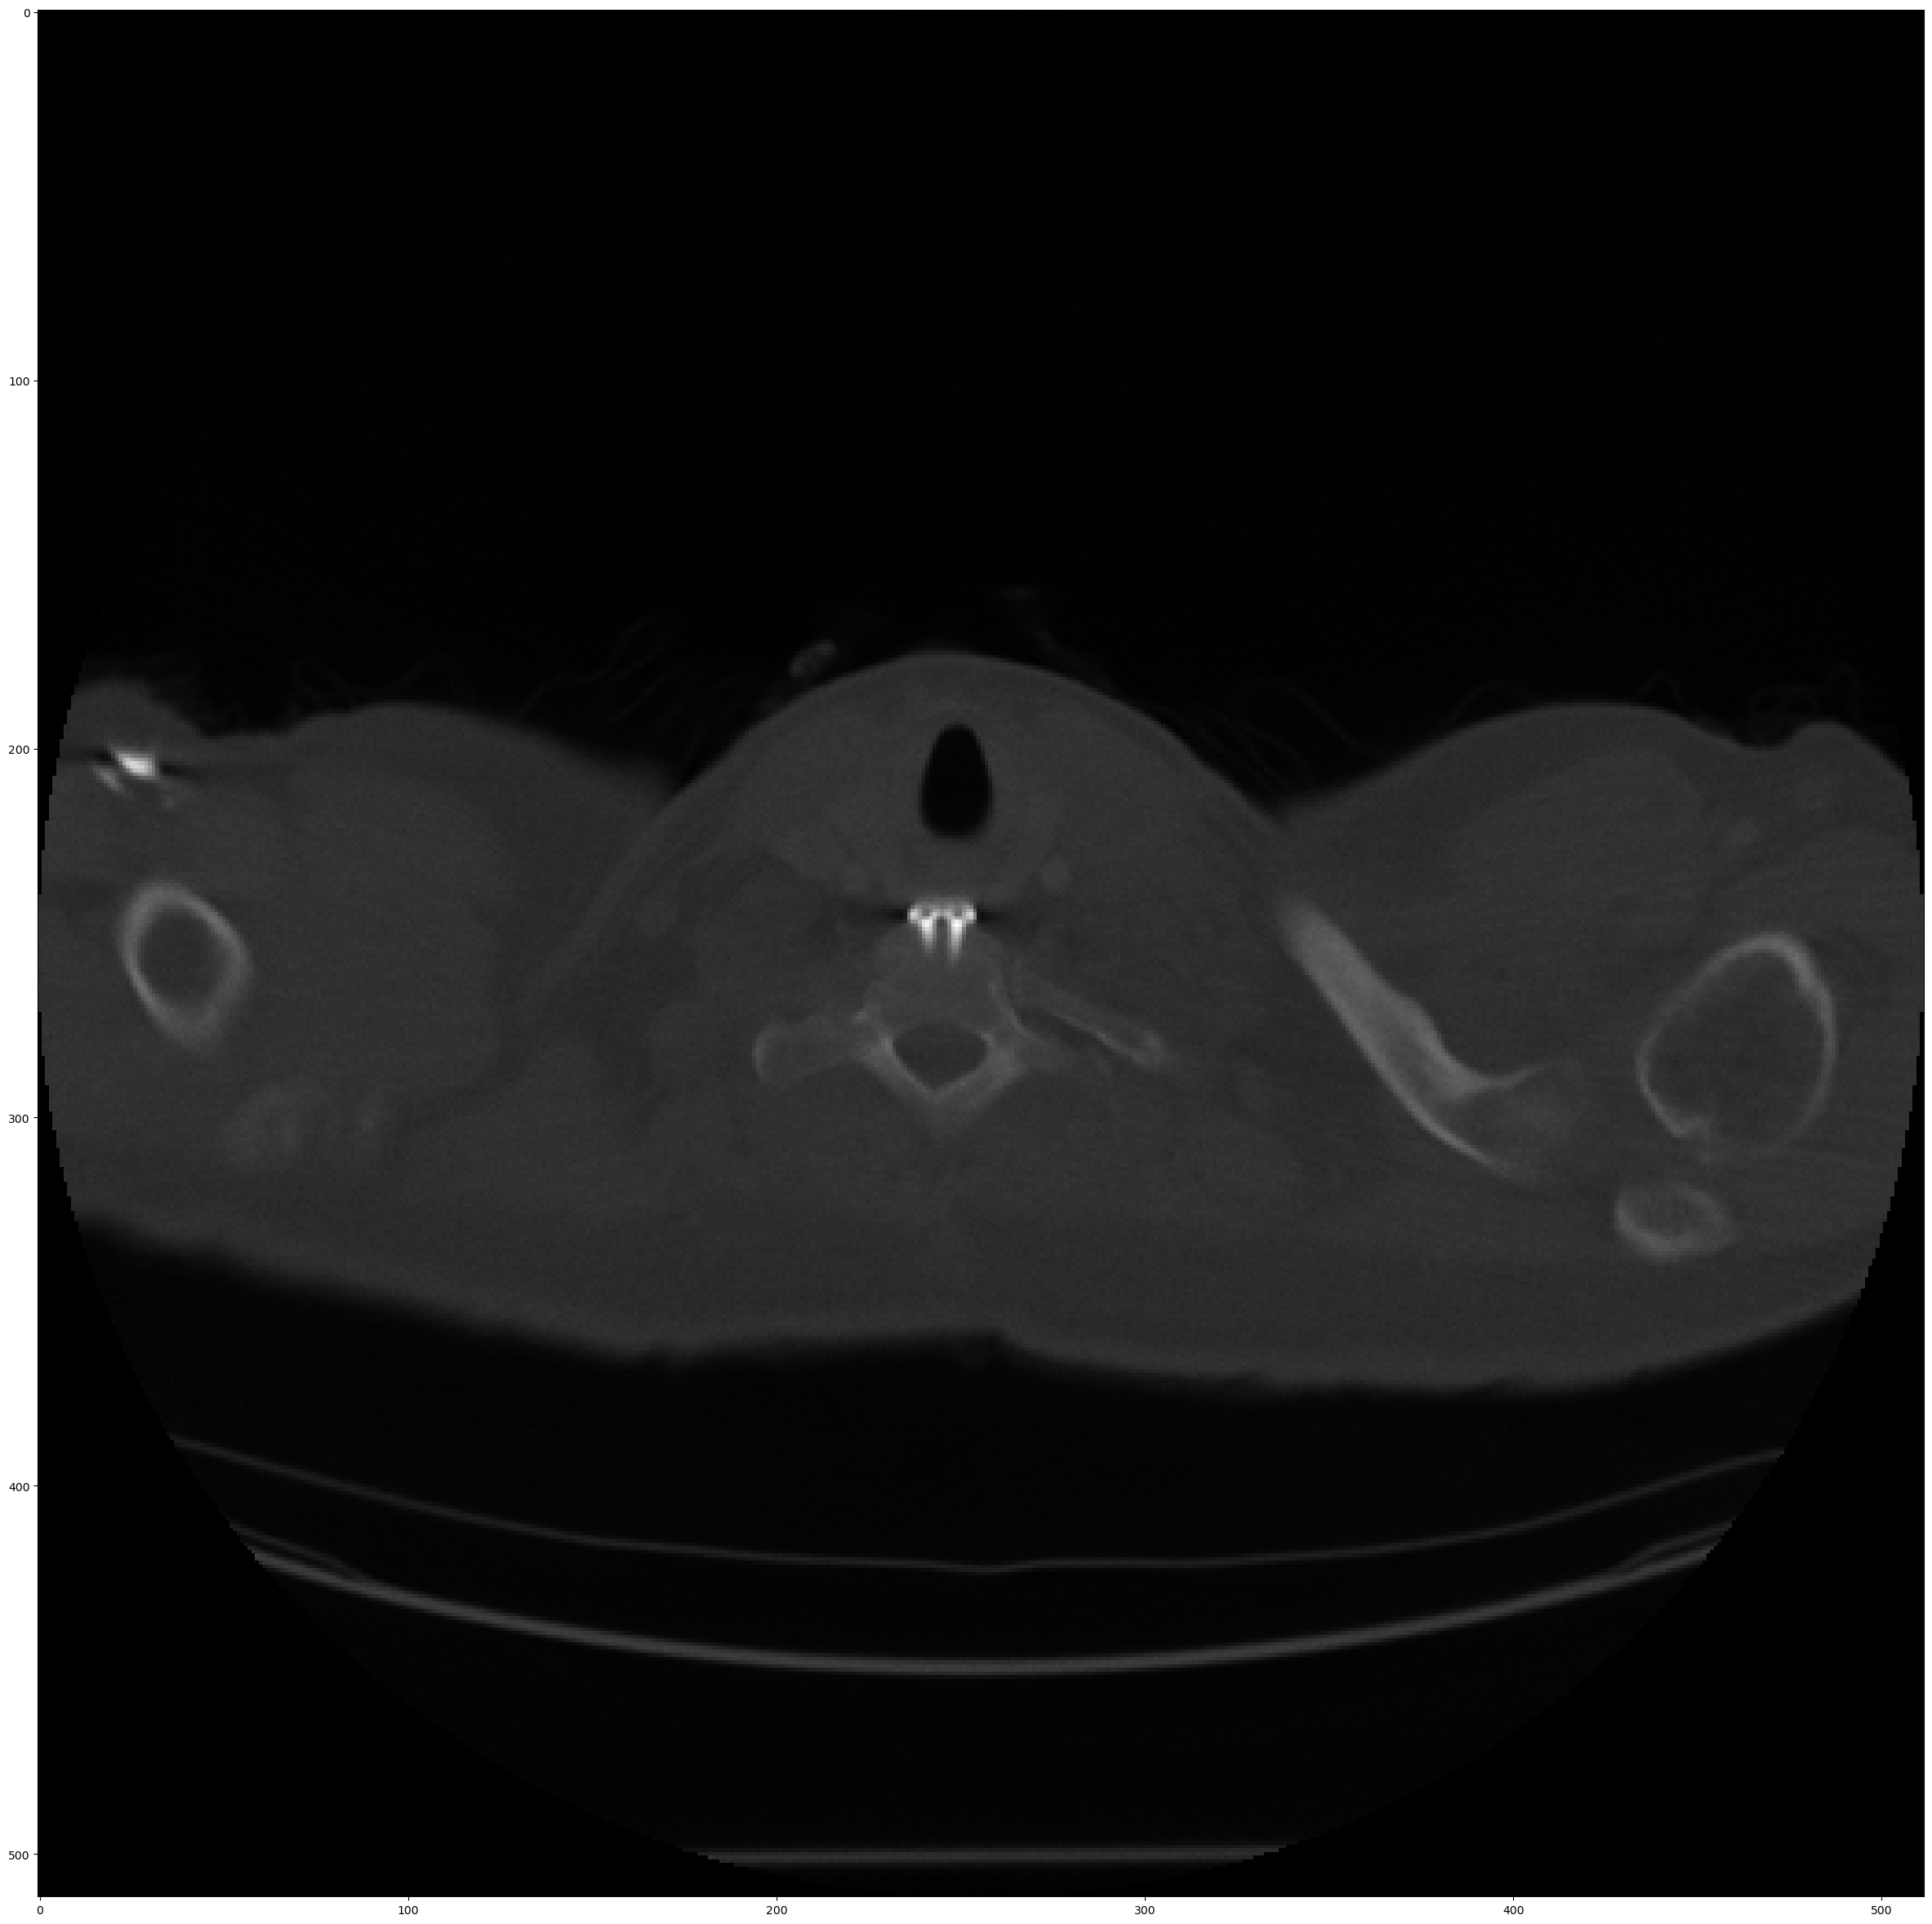

In [116]:
dcm = pydicom.dcmread('/Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Image/S0819-P200936563/12-29-1959-NA-CT Chest With Contrast-96665/poisson/1-01.dcm')

image = dcm.pixel_array

plt.figure(figsize=(30,30))
plt.imshow(image, cmap="gray")
plt.show